In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import time
import scipy.signal as ss
from sklearn import preprocessing
import tensorflow as tf
import math

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
R = loadmat('/content/drive/My Drive/Sem_2/data_32k.mat')
spec1= loadmat('/content/drive/My Drive/Sem_2/label_32k.mat')
test1= loadmat('/content/drive/My Drive/Sem_2/test_27&9.mat')
test2= loadmat('/content/drive/My Drive/Sem_2/test_41&1.mat')

#data

In [ ]:
R

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Apr 29 08:37:52 2023',
 '__version__': '1.0',
 '__globals__': [],
 'cov_data': array([[array([[[ 1.41625902e-08,  0.00000000e+00,  0.00000000e+00],
                 [ 7.71512116e-09, -1.18349988e-08, -9.93093383e-01],
                 [-5.67527989e-09, -1.28625968e-08, -1.98632778e+00],
                 [-1.37745920e-08, -2.24862103e-09, -2.97977587e+00],
                 [-9.30851309e-09,  1.02175917e-08,  2.30967100e+00],
                 [ 3.44728206e-09,  1.32127005e-08,  1.31557917e+00]],
 
                [[ 7.71512116e-09,  1.18349988e-08,  9.93093383e-01],
                 [ 1.41281664e-08,  0.00000000e+00,  0.00000000e+00],
                 [ 7.69641227e-09, -1.18081487e-08, -9.93165033e-01],
                 [-5.66465171e-09, -1.28334496e-08, -1.98647337e+00],
                 [-1.37463792e-08, -2.24087657e-09, -2.97999829e+00],
                 [-9.28737206e-09,  1.02002341e-08,  2.30938550e+00]],
 
   

In [ ]:
R1=R['cov_data']

In [ ]:
spec=spec1['label']

In [ ]:
#num_rows = len(spec1)
#num_cols = len(spec1['label'])
#print(f"The 2D dictionary has {num_rows} rows and {num_cols} columns.")

#R=data['Cov'] #covariance matrix
#spec1=data['Spectrum']
# region=preprocessing.normalize(spec1)
# region.shape
#type(region)
#region=preprocessing.normalize(spec1)
#spec=np.transpose((spec1))

R1.shape,spec.shape

((32000, 1), (32000, 1201))

In [ ]:


M=6
speed=1500
frequ=10000
lamda = speed/frequ
d=lamda/2
N=1201 #output neurons
thetaStart=-np.pi/3
thetaFinal=np.pi/3

Ja=32000
#SNR=[10,8,6,4,2,0,-2,-4,-6,-8,-10,-12,-14,-16,-18,-20]
Angles=np.linspace(thetaStart,thetaFinal,1201)*180/np.pi


In [ ]:
Angles
#plt.plot(Angles,spec1[11,:])

array([-60. , -59.9, -59.8, ...,  59.8,  59.9,  60. ])

In [ ]:
samp=Ja
Xu=np.zeros((samp,M,M,3))
Xu.shape



(32000, 6, 6, 3)

In [ ]:
for i in range (samp):
    a=R1[i]
    Xu[i,:,:,:]=a[0]  

# Rx=np.transpose((Xu))
Xu.shape#,Rx.shape


(32000, 6, 6, 3)

In [ ]:
inputs = tf.keras.layers.Input((M,M,3))
x = tf.keras.layers.Conv2D(256, (3, 3), strides= 1, activation= None,name="cnn_L1", padding="same")(inputs)
x = tf.keras.layers.BatchNormalization( axis=-1, center=True, scale=True)(x) # this is included ,
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)
x = tf.keras.layers.Conv2D(256, (2, 2), strides= 1, activation= None,name="cnn_2", padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, center=True, scale=True)(x) # this is included
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)
x = tf.keras.layers.Conv2D(256, (2, 2), strides= 1, activation= None,name="cnn_3", padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, center=True, scale=True)(x) # this is included
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x) 
x = tf.keras.layers.Conv2D(256, (2, 2), strides= 1, activation= None,name="cnn_4", padding="same")(x)
x = tf.keras.layers.BatchNormalization(axis=-1, center=True, scale=True)(x) # this is included
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation = None, name = 'FC1')(x)
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation = None, name = 'FC2')(x) 
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(2048, activation = None, name = 'FC3')(x)
x = tf.keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)(x) 
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(N, activation = None, name = 'FC4')(x)
out = tf.keras.layers.Dense(N, activation = None, name = 'FC4')(x)
#changed axis from 1 to -1 in normalization layer

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.005
   drop = 0.3            # "drop" variable is between 0.5 and 0.1
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3,verbose=1, mode='min')]
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [ ]:
model = tf.keras.Model(inputs = [inputs], outputs = [out])
optimizer=tf.keras.optimizers.Adam(learning_rate=0.005,beta_1=0.9,beta_2=0.999,epsilon=1e-08)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=[tf.keras.metrics.BinaryCrossentropy()])
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 6, 3)]         0         
                                                                 
 cnn_L1 (Conv2D)             (None, 6, 6, 256)         7168      
                                                                 
 batch_normalization (BatchN  (None, 6, 6, 256)        1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 6, 6, 256)         0         
                                                                 
 cnn_2 (Conv2D)              (None, 6, 6, 256)         262400    
                                                                 
 batch_normalization_1 (Batc  (None, 6, 6, 256)        1024      
 hNormalization)                                             

In [ ]:
np.random.RandomState(123).shuffle(Xu)
np.random.RandomState(123).shuffle(spec)


In [ ]:
result = model.fit(Xu,spec, epochs =25, batch_size=64, shuffle = True,callbacks=[callbacks, my_lr_scheduler], verbose = 1,validation_split=0.1) #[callbacks, my_lr_scheduler]

Epoch 1/25
450/450 [==============================] - 28s 32ms/step - loss: 0.0105 - binary_crossentropy: 0.0153 - val_loss: 0.0068 - val_binary_crossentropy: 0.0128 - lr: 0.0050
Epoch 2/25
450/450 [==============================] - 13s 30ms/step - loss: 0.0057 - binary_crossentropy: 0.0128 - val_loss: 0.0051 - val_binary_crossentropy: 0.0128 - lr: 0.0050
Epoch 3/25
450/450 [==============================] - 13s 28ms/step - loss: 0.0053 - binary_crossentropy: 0.0128 - val_loss: 0.0049 - val_binary_crossentropy: 0.0128 - lr: 0.0050
Epoch 4/25
450/450 [==============================] - 14s 30ms/step - loss: 0.0050 - binary_crossentropy: 0.0129 - val_loss: 0.0045 - val_binary_crossentropy: 0.0128 - lr: 0.0050
Epoch 5/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0046 - binary_crossentropy: 0.0129 - val_loss: 0.0041 - val_binary_crossentropy: 0.0128 - lr: 0.0050
Epoch 6/25
450/450 [==============================] - 16s 35ms/step - loss: 0.0042 - binary_crossentropy:

In [ ]:
model.save('my_model.h5')

In [ ]:
import numpy as np
from tensorflow import keras

# Reshape the test data to the required input shape of the model
test_data = R1

# Normalize the test data
#test_data = test_data

# Load the trained model
model = keras.models.load_model('my_model.h5')

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




In [ ]:
data=test1['covariance']

In [ ]:
data = data.reshape(1, 6, 6, 3)
#data = np.expand_dims(data, axis=-1)

predictions = model.predict(data)
max_index = np.argmax(predictions)
Predicted_angle = max_index/10 - 60
print(Predicted_angle)

1/1 [==============================] - 0s 20ms/step
28.0


In [ ]:
predictions

array([[-12.31096 , -12.328148, -11.933693, ...,  -9.345469,  -9.520515,
        -12.975177]], dtype=float32)

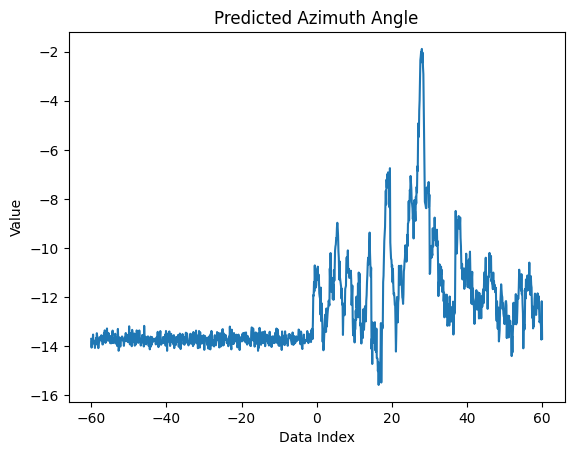

In [ ]:
# Plot the data as a 2D graph
plt.plot(Angles,predictions[0])
plt.xlabel('Data Index')
plt.ylabel('Value')
plt.title('Predicted Azimuth Angle')
plt.show()

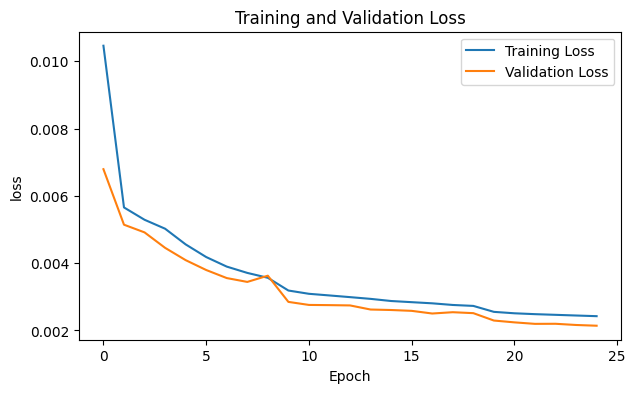

In [ ]:
figsize=7,4
figure,ax=plt.subplots(figsize=figsize)
plt.plot(result.history['loss'],label='Training Loss')
plt.plot(result.history['val_loss'],label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#model.save('/content/drive/My Drive')

In [ ]:
def array_steering_vector(array,DOA):
    v = np.exp(-1j*2*np.pi*array*np.sin(np.deg2rad(DOA)))
    return v

In [ ]:
#NEW REXCTIFIED TESTING ONE
DOA = np.array([0,15])
L=len(DOA)
SNR=-15
T=200
array = np.linspace(0,(M-1)/2,M)
sigma_Noise = (10**(-SNR/20))/M
steering=np.zeros((M,L)) + 1j*np.zeros((M,L))
for i in range(L):
  steering[:,i]=array_steering_vector(array,DOA[i])
#np.random.seed(64)
s1=np.multiply(np.transpose(np.matrix(steering[:,0])),np.random.randn(1,T))
s2=np.multiply(np.transpose(np.matrix(steering[:,1])),np.random.randn(1,T))
#s3=np.multiply(np.transpose(np.matrix(steering[:,2])),np.random.randn(1,T)) 
noise = np.matrix(np.zeros((M,T)) + 1j*np.zeros((M,T)))
for iter in range(T):
    noise[:,iter]=(sigma_Noise)*np.matrix((np.random.randn(M,1) + 1j*np.random.randn(M,1)))
    
Xu=s1+s2+noise
Cov = (1/T)*Xu@Xu.conj().transpose() 
CovMattest=Cov/LA.norm(Cov)
Xutest=np.zeros((M,M,3))
Xutest[:,:,0]=np.real(CovMattest)
Xutest[:,:,1]=np.imag(CovMattest)
Xutest[:,:,2]=np.angle(CovMattest)
Xutest=np.expand_dims(Xutest,axis=0)
Xutest.shape
pred = tf.math.sigmoid(model.predict(Xutest))
predi=np.transpose(pred)
DD=predi.flatten(order='C')
DD=DD/max(DD)
peaks= ss.find_peaks(DD,height=0.6,distance=1.0,prominence=0.5)
a=peaks[0]
location=Angles[a]
f=peaks[1]
dd=f['peak_heights']
plt.plot(Angles,DD)
plt.scatter(location,dd,color='red',marker='*')
#ply.scatter(DOA,)
plt.xlabel('Theta')
plt.ylabel('Not Power Spectrum')
plt.title('Direction of ARRIVAL')
plt.show()

In [ ]:
location

In [ ]:
#Performance evaluation for ARMSE
DOA = np.array([0,8])
L=len(DOA)
SNR=-12
T=500
simulations=1000
array = np.linspace(0,(M-1)/2,M)
sigma_Noise = (10**(-SNR/20))/M
steering=np.zeros((M,L)) + 1j*np.zeros((M,L))
for i in range(L):
  steering[:,i]=array_steering_vector(array,DOA[i])
#np.random.seed(64)

error=np.matrix(np.zeros((simulations,L)))
for jj in range(simulations):
  s1=np.multiply(np.transpose(np.matrix(steering[:,0])),np.random.randn(1,T))
  s2=np.multiply(np.transpose(np.matrix(steering[:,1])),np.random.randn(1,T))
  #s3=np.multiply(np.transpose(np.matrix(steering[:,2])),np.random.randn(1,T)) 
  noise = np.matrix(np.zeros((M,T)) + 1j*np.zeros((M,T)))
  for iter in range(T):
     noise[:,iter]=(sigma_Noise)*np.matrix((np.random.randn(M,1) + 1j*np.random.randn(M,1)))
  Xu=s1+s2+noise
  Cov = (1/T)*Xu@Xu.conj().transpose() 
  CovMattest=Cov/LA.norm(Cov)
  Xutest=np.zeros((M,M,3))
  Xutest[:,:,0]=np.real(CovMattest)
  Xutest[:,:,1]=np.imag(CovMattest)
  Xutest[:,:,2]=np.angle(CovMattest)
  Xutest=np.expand_dims(Xutest,axis=0)
  Xutest.shape
  pred = tf.math.sigmoid(model.predict(Xutest))
  predi=np.transpose(pred)
  DD=predi.flatten(order='C')
  DD=DD/max(DD)
  peak_indices, peak_dict= ss.find_peaks(DD,height=0.2,distance=1)
  peak_heights = peak_dict['peak_heights']
  df = pd.DataFrame(peak_indices, columns = {'locs'})
  df['heights'] = peak_heights
  final_df = df.sort_values(by=['heights'], ascending=False)
  ll=final_df.iloc[[0,1],:]
  location=sorted(Angles[ll.locs.to_numpy()])
  error[jj,:]=(location-DOA)**2 
  sum_error=np.sqrt((error.sum(axis=0))/simulations)
  ARMSE=(sum_error.sum(axis=1))/L

plt.plot(Angles,DD)
# plt.scatter(location,peak_heights,color='red',marker='*')
plt.xlabel('Theta')
plt.ylabel('Not Power Spectrum')
plt.title('Direction of ARRIVAL')
plt.show()
ARMSE,location

In [ ]:
# #RESOLUTION PROBABILITY
DOA = np.array([0,8])
L=len(DOA)
SNR=10
T=500
simulations=1000
array = np.linspace(0,(M-1)/2,M)
sigma_Noise = (10**(-SNR/20))/M
steering=np.zeros((M,L)) + 1j*np.zeros((M,L))
for i in range(L):
  steering[:,i]=array_steering_vector(array,DOA[i])
#np.random.seed(64)

error=np.matrix(np.zeros((simulations,L)))
for jj in range(simulations):
  s1=np.multiply(np.transpose(np.matrix(steering[:,0])),np.random.randn(1,T))
  s2=np.multiply(np.transpose(np.matrix(steering[:,1])),np.random.randn(1,T))
  #s3=np.multiply(np.transpose(np.matrix(steering[:,2])),np.random.randn(1,T)) 
  noise = np.matrix(np.zeros((M,T)) + 1j*np.zeros((M,T)))
  for iter in range(T):
     noise[:,iter]=(sigma_Noise)*np.matrix((np.random.randn(M,1) + 1j*np.random.randn(M,1)))
  Xu=s1+s2+noise
  Cov = (1/T)*Xu@Xu.conj().transpose() 
  CovMattest=Cov/LA.norm(Cov)
  Xutest=np.zeros((M,M,3))
  Xutest[:,:,0]=np.real(CovMattest)
  Xutest[:,:,1]=np.imag(CovMattest)
  Xutest[:,:,2]=np.angle(CovMattest)
  Xutest=np.expand_dims(Xutest,axis=0)
  Xutest.shape
  pred = tf.math.sigmoid(model.predict(Xutest))
  predi=np.transpose(pred)
  DD=predi.flatten(order='C')
  DD=DD/max(DD)
  peak_indices, peak_dict= ss.find_peaks(DD,height=0.2,distance=1)
  peak_heights = peak_dict['peak_heights']
  df = pd.DataFrame(peak_indices, columns = {'locs'})
  df['heights'] = peak_heights
  final_df = df.sort_values(by=['heights'], ascending=False)
  ll=final_df.iloc[[0,1],:]
  location=sorted(Angles[ll.locs.to_numpy()])
  error[jj,:]=(location-DOA)**2 
  Reso=np.sqrt(error)
  l = len(Reso)
  threshold = (DOA[0] + DOA[1])/2
  cnt = 0

  for i in range (0, l):
    if (Reso[i,0] < threshold and Reso[i,1] < threshold):
      cnt = cnt + 1

  res_prob = cnt/simulations

plt.plot(Angles,DD)
# plt.scatter(location,peak_heights,color='red',marker='*')
plt.xlabel('Theta')
plt.ylabel('Not Power Spectrum')
plt.title('Direction of ARRIVAL')
plt.show()
ARMSE,location, res_prob
